In [10]:
# Libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [13]:
# Reading in ethinicity data file without header to avoid duplicate columns being renamed automatically
url_eth = ''
df = pd.read_csv("clean_data/ethinicity_data_by_msoa_2.csv", header = None, low_memory=False)

# Assigining top row as head
new_header = df.iloc[0] #grab the first row
df = df[1: ] #take the data less the header row
df.columns = new_header #set the header row as the df header

In [14]:
# Selecting london data based on MSOA code
url_ldnData = ''
ldnData = pd.read_csv("clean_data/msoa-data-london.csv", low_memory=False)
dfLnd = pd.merge (df, ldnData, how='right',on=["MSOA Code","MSOA Name"])
dfLnd.dropna(axis = 0, inplace = True)

# Combining duplicate column data as a sum
df1 = dfLnd.groupby(dfLnd.columns, axis=1).agg(np.max)

In [16]:
# Cleaning ethinicity dataframe
df1.drop(columns=["date","Rural Urban"],inplace = True)#removing date column

# Cleaning column names
df1.columns = df1.columns.str.replace(' ', '_') #replacing spcae with underscore
df1.columns = df1.columns.str.replace('/', '_') #replacing spcae with underscore

# Arranging columns
dfA = df1[['MSOA_Code','MSOA_Name','All','White']]
dfB = df1[df1.columns.drop(dfA.columns.tolist())]
dfEth = pd.concat([dfA, dfB], axis=1, join="outer")

In [18]:
# Rescaling ethinicity data (inter-Quartile Standardisation)
cList = dfEth.columns.tolist()
dfResc = dfEth[cList[2:]].copy() #new dataframe to rescale and converting all count to int
cols = dfResc.columns.tolist() #creating list of columns to be rescaled

rs = RobustScaler(quantile_range=(25.0, 75.0))
scalers = [rs.fit(dfResc[x].values.reshape(-1,1)) #array of scaled values
           for x in cols] #loop rescaling values between 0 to 1 and fitting data

dfResc2 = dfResc.copy()
for i in range(0, len(cols)):
    dfResc2[cols[i]] = rs.transform(dfResc[cols[i]].values.reshape(-1,1)) #loop for transforming array to dataframe structure

dfStan2 = pd.concat([dfEth[['MSOA_Code','MSOA_Name']], dfResc2], axis=1, join="outer") #final rescaled ethinicity data

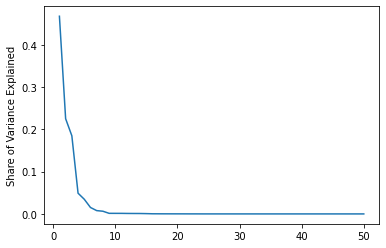

Component  0 accounts for 46.74% of variance
Component  1 accounts for 22.51% of variance
Component  2 accounts for 18.48% of variance
Component  3 accounts for 4.90% of variance
Component  4 accounts for 3.47% of variance
Component  5 accounts for 1.52% of variance
Component  6 accounts for 0.78% of variance
Component  7 accounts for 0.64% of variance
Component  8 accounts for 0.14% of variance
Component  9 accounts for 0.13% of variance
Component 10 accounts for 0.13% of variance
Component 11 accounts for 0.11% of variance
Component 12 accounts for 0.10% of variance
Component 13 accounts for 0.10% of variance
Component 14 accounts for 0.07% of variance
Component 15 accounts for 0.03% of variance
Component 16 accounts for 0.03% of variance
Component 17 accounts for 0.02% of variance
Component 18 accounts for 0.02% of variance
Component 19 accounts for 0.02% of variance


In [21]:
# Principle Component Analysis (PCA) to reduce variables
pca = PCA(n_components=50, whiten=True) #setting up PCA
dfRed = dfResc2.drop(['All', 'White'], axis = 1) #variables to use for PCA (removing 'white' and 'all' as they will not contribute to minority ethinicity analysis to be done using PCA results)
pca.fit(dfRed)

explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

# Plotting components' explained variance elbow plot
x = np.arange(1,len(explained_variance)+1)
plt.plot(x, explained_variance)
plt.ylabel('Share of Variance Explained')
plt.show()

for i in range(0, 20):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

In [24]:
# Selecting top 10 PCA components based on previous elbow plot
keep_n_components = 10 #components to keep
pca = PCA(n_components=keep_n_components, whiten=True) #setting up PCA for top 10 components
dfRed_pca = pca.fit_transform(dfRed)

dfRed_pca = dfRed_pca.T #transforming array to match rtdataframe structure
mEthPca = pd.DataFrame()
for i in range (0, keep_n_components):
    mEthPca[f"Component_{i+1}"] = dfRed_pca[i]
mEthPca #minority ethinicity components

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10
0,-0.41,-1.01,0.25,-0.27,0.17,0.07,0.12,1.97,0.19,-0.22
1,-0.36,0.10,-0.12,-0.03,0.45,-0.48,-0.28,-0.23,-0.65,0.91
2,0.39,0.82,0.35,0.53,0.32,-0.58,-0.13,0.14,-0.50,0.91
3,-0.64,-0.45,-0.16,-0.15,0.55,-0.61,-0.18,-0.27,-0.16,-0.25
4,-0.32,0.61,0.01,-0.23,0.98,-0.63,-0.04,-0.43,-0.51,0.98
...,...,...,...,...,...,...,...,...,...,...
978,-0.48,-0.68,-0.09,-0.17,0.46,0.86,-0.33,-0.87,0.44,-0.38
979,-0.41,-0.35,0.32,-0.34,0.45,1.10,-0.32,-0.99,0.21,-0.35
980,-0.49,-0.77,-0.02,-0.03,0.26,0.50,-0.34,-0.73,0.46,-0.10
981,-0.48,-0.32,0.33,-0.12,0.44,1.99,-0.23,-1.18,0.02,-0.42
